In [1]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
synthetic_calls_path = '../data/binom_synthetic_calls.csv'
synthetic_puts_path = '../data/binom_synthetic_puts.csv'

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [5]:
synthetic_calls = pd.read_csv(synthetic_calls_path, index_col=0)
synthetic_puts = pd.read_csv(synthetic_puts_path, index_col=0)

synthetic_calls = reduce_mem_usage(synthetic_calls)
synthetic_puts = reduce_mem_usage(synthetic_puts)

In [6]:
synthetic_options = pd.concat([synthetic_calls, synthetic_puts], axis=0)
synthetic_options = shuffle(synthetic_options, random_state=0)
synthetic_options = synthetic_options.reset_index()
synthetic_options = synthetic_options.drop('index', axis=1)

In [7]:
synthetic_options.head(5)

,Price,Strike,Type,Vol,Interest Rate,Time to Expiration,Option Price
0,100,97.0,C,0.799805,0.070007,0.600098,27.125000
1,100,101.0,P,0.500000,0.099976,0.600098,12.671875
2,100,90.0,P,0.300049,0.059998,0.899902,4.707031
3,100,104.0,P,0.899902,0.090027,0.899902,30.390625
4,100,144.0,C,1.000000,0.099976,0.899902,28.078125


# Preprocessing

In [8]:
synthetic_options = pd.get_dummies(synthetic_options, prefix='', prefix_sep='')

In [9]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(synthetic_options.drop('Option Price', axis=1))
output_data = output_sc.fit_transform(synthetic_options['Option Price'].values.reshape(-1, 1))

train_size = 0.8
val_size = 0.1

last_train_idx = int(np.round(len(input_data) * train_size))
last_val_idx = last_train_idx + int(np.round(len(input_data) * val_size))

X_train = input_data[0:last_train_idx]
X_val = input_data[last_train_idx:last_val_idx]
X_test = input_data[last_val_idx:]

y_train = output_data[0:last_train_idx]
y_val = output_data[last_train_idx:last_val_idx]
y_test = output_data[last_val_idx:]

In [10]:
X_train = Variable(torch.Tensor(X_train))
X_val = Variable(torch.Tensor(X_val))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_val = Variable(torch.Tensor(y_val))
y_test = Variable(torch.Tensor(y_test))

 # Model

In [11]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [12]:
class ResBlock(nn.Module):

  def __init__(self, module):
    super(ResBlock, self).__init__()
    self.module = module

  def forward(self, x):
    return self.module(x) + x

In [13]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size):
      super(HiddenLayer, self).__init__()
      self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU()
      )
    
  def forward(self, x):
    return self.layer(x)

In [14]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    self.net = nn.Sequential(
        nn.Linear(self.input_size, self.hidden_size),
        nn.LeakyReLU(),
        ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size),
                HiddenLayer(self.hidden_size)
            )
        ),
        ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size),
                HiddenLayer(self.hidden_size)
            )
        ),
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

# Training

In [15]:
input_size = 7
hidden_size = 400
output_size = 1
batch_size = 1208
epochs = 1000
lr = 1e-4

model = Net(input_size, output_size, hidden_size)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
model = model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [17]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

In [18]:
def evaluate(model, loss_fn, X_val, y_val):
  model.eval()
  with torch.no_grad():
    out = model(X_val)
    loss = loss_fn(out, y_val)
    print('\nVal set: Average loss: {:.8f}\n'.format(
            loss.item()))
    return loss.item()

In [19]:
def train(
    epochs, 
    batch_size, 
    model,
    optimizer,
    loss_fn, 
    X_train,
    y_train,
    X_val,
    y_val
):

  training_losses = []
  validation_losses = []

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()
    i = 0

    for batch, batch_labels in DataLoader(OptDataset(X_train, y_train), batch_size=batch_size):
      out = model(batch.to(device))
      optimizer.zero_grad()

      loss = loss_fn(out, batch_labels.to(device))
      epoch_losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(X_train) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1
    
    training_losses.append(np.array(epoch_losses).mean())
    validation_losses.append(evaluate(model, loss_fn, X_val, y_val))

  return training_losses, validation_losses

In [20]:
load = False
save_model_path = f'../models/opt_resnet_h{hidden_size}.chkpt'
val_err_df_path = f'../results/val_resnet_{hidden_size}.csv'

if not load:
  train_losses, val_losses = train(
      epochs, 
      batch_size, 
      model, 
      optimizer, 
      loss_fn, 
      X_train, 
      y_train,
      X_val,
      y_val)
  val_err_df = pd.DataFrame({
      'Training': train_losses, 
      'Validation': val_losses})
  val_err_df.to_csv(val_err_df_path)
  torch.save(model.state_dict(), save_model_path)
else:
  model = Net(input_size, output_size, hidden_size)
  model.load_state_dict(torch.load(save_model_path, map_location=device))
  val_err_df = pd.read_csv(val_err_df_path, index_col=0)

| Epoch   0 |    50/  401 batches | lr 0.00010 | ms/batch 26.64 | loss 0.31802076
| Epoch   0 |   100/  401 batches | lr 0.00010 | ms/batch 20.45 | loss 0.01173025
| Epoch   0 |   150/  401 batches | lr 0.00010 | ms/batch 23.07 | loss 0.00424041
| Epoch   0 |   200/  401 batches | lr 0.00010 | ms/batch 21.60 | loss 0.00171376
| Epoch   0 |   250/  401 batches | lr 0.00010 | ms/batch 21.25 | loss 0.00084345
| Epoch   0 |   300/  401 batches | lr 0.00010 | ms/batch 21.83 | loss 0.00053759
| Epoch   0 |   350/  401 batches | lr 0.00010 | ms/batch 20.20 | loss 0.00040296

Val set: Average loss: 0.00029235

| Epoch   1 |    50/  401 batches | lr 0.00010 | ms/batch 22.38 | loss 0.00027336
| Epoch   1 |   100/  401 batches | lr 0.00010 | ms/batch 20.44 | loss 0.00023159
| Epoch   1 |   150/  401 batches | lr 0.00010 | ms/batch 22.05 | loss 0.00020460
| Epoch   1 |   200/  401 batches | lr 0.00010 | ms/batch 20.51 | loss 0.00018416
| Epoch   1 |   250/  401 batches | lr 0.00010 | ms/batch 24.3

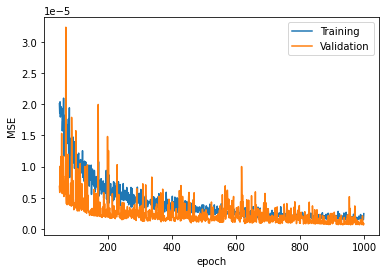

In [21]:
val_err_df[50:].plot(xlabel='epoch', ylabel='MSE');

# Test the model

In [22]:
test_size = 30
test_out = model(X_test[0:test_size])
test_out = output_sc.inverse_transform(test_out.cpu().detach().numpy())
real_out = output_sc.inverse_transform(y_test[0:test_size].cpu().detach().numpy())

In [23]:
cols = ['Price', 'Strike', 'Vol', 'Interest Rate', 'Time to Expiration', 'C', 'P', 'Prediction', 'Real']
test_options = pd.DataFrame(columns=cols)

In [24]:
for i, item in enumerate(input_sc.inverse_transform(X_test[0:test_size].cpu().detach().numpy())):
  opt = {
      'Price': item[0],
      'Strike': item[1],
      'Vol': item[2],
      'Interest Rate': item[3],
      'Time to Expiration': item[4],
      'C': item[5],
      'P': item[6],
      'Prediction': test_out[i][0],
      'Real': real_out[i][0]
  }
  test_options = test_options.append(opt, ignore_index=True)

In [25]:
test_options['Moneyness'] = test_options.Price / test_options.Strike
test_options['Abs Error'] = np.abs(test_options.Prediction - test_options.Real)

In [26]:
test_options.sort_values('Abs Error')

,Price,Strike,Vol,Interest Rate,Time to Expiration,C,P,Prediction,Real,Moneyness,Abs Error
29,100.0,177.017334,0.500008,0.009982,0.999894,0.0,1.0,79.516945,79.517090,0.564916,0.000145
11,100.0,62.979340,0.950163,0.029996,0.700190,0.0,1.0,9.965315,9.964779,1.587822,0.000536
16,100.0,76.984009,0.300025,0.059995,0.199936,0.0,1.0,0.086591,0.084669,1.298971,0.001923
17,100.0,162.991379,0.099831,0.090037,0.499990,1.0,0.0,-0.002234,-0.006693,0.613529,0.004459
25,100.0,185.019989,0.149950,0.040010,0.799764,0.0,1.0,79.209549,79.203850,0.540482,0.005699
14,100.0,74.983337,0.649872,0.099995,0.999894,1.0,0.0,40.969398,40.975533,1.333630,0.006134
8,100.0,190.979431,0.149950,0.070009,0.299931,0.0,1.0,87.015381,87.008751,0.523617,0.006630
1,100.0,175.995712,0.649872,0.090037,0.100082,1.0,0.0,0.039865,0.032463,0.568196,0.007402
26,100.0,156.010330,0.500008,0.090037,0.899759,0.0,1.0,50.990837,50.999207,0.640983,0.008369
22,100.0,62.979340,0.250047,0.009982,0.399785,1.0,0.0,37.264378,37.255806,1.587822,0.008572


### MSE on the test set

In [27]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The MSE on the test set is: ', loss.item())

The MSE on the test set is:  8.363261372323905e-07


### MAE on the test set

In [28]:
model.eval()
mae_loss = nn.L1Loss()
with torch.no_grad():
    out = model(X_test)
    loss = mae_loss(out, y_test)
    print('The MAE on the test set is: ', loss.item())

The MAE on the test set is:  0.0007248659385368228


### RMSE on the test set

In [29]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The RMSE on the test set is: ', np.sqrt(loss.item()))

The RMSE on the test set is:  0.0009145086862531107


### MAPE on the test set

In [30]:
def mape_loss(y_pred, y):
  return sum([np.abs(y_i - hy_i) / y_i for y_i, hy_i in zip(y_pred, y)]) / len(y_pred)

In [31]:
model.eval()
with torch.no_grad():
    out = model(X_test).squeeze().cpu().detach().numpy()
    loss = mape_loss(out, y_test.squeeze().cpu().detach().numpy())
    print('The MAPE on the test set is: ', loss)

The MAPE on the test set is:  0.0026164434280950997
